In [ ]:
'''
COMPSCI 760 Group Project :Extending NCP to supervised learning - traffic dataset 
Found at https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Original NCP repo :https://github.com/mlech26l/keras-ncp
Original LTC repo :https://github.com/raminmh/liquid_time_constant_networks
'''

'\nCOMPSCI 760 Group Project :Extending NCP to supervised learning - traffic dataset \nFound at https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz\nOriginal NCP repo :https://github.com/mlech26l/keras-ncp\nOriginal LTC repo :https://github.com/raminmh/liquid_time_constant_networks\n'

In [ ]:
import pandas
import numpy as np
import tensorflow as tf
from tensorflow import keras
from kerasncp import wirings
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
import kerasncp

In [ ]:
# change the directory here if needed
traffic_data = pandas.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [ ]:
pandas.DataFrame.info(traffic_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [ ]:
pandas.DataFrame.describe(traffic_data)

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [ ]:
import matplotlib.pyplot as plt
import datetime
import scipy.stats

In [ ]:
holiday = (traffic_data["holiday"].values == None).astype(np.float32)
temp = traffic_data["temp"].values.astype(np.float32)
temp -= np.mean(temp) #normalize temp by annual mean
rain = traffic_data["rain_1h"].values.astype(np.float32)
snow = traffic_data["snow_1h"].values.astype(np.float32)
clouds = traffic_data["clouds_all"].values.astype(np.float32)
date_time = traffic_data["date_time"].values
    #2012-10-02 13:00:00
date_time = [datetime.datetime.strptime(d,"%Y-%m-%d %H:%M:%S") for d in date_time]
weekday = np.array([d.weekday() for d in date_time]).astype(np.float32)
noon = np.array([d.hour for d in date_time]).astype(np.float32)
noon = np.sin(noon*np.pi/24)

features = np.stack([holiday,temp,rain,snow,clouds,weekday,noon],axis=-1)

traffic_volume = traffic_data["traffic_volume"].values.astype(np.float32)
traffic_volume -= np.mean(traffic_volume) #normalize
traffic_volume /= np.std(traffic_volume) #normalize

<AxesSubplot:ylabel='Density'>

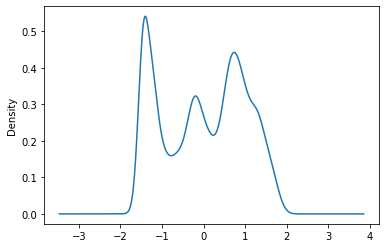

In [ ]:
# pdf of traffic-volume
pandas.Series(traffic_volume).plot.kde()

In [ ]:
#np.savetxt("preprocessed_traffic_data.csv", features, delimiter=",")

In [ ]:
# change the directory here if needed
preprocessed_traffic_data = pandas.read_csv('preprocessed_traffic_data.csv')

In [ ]:
pandas.DataFrame.describe(preprocessed_traffic_data)

,holiday,temp,rain,snow,clouds,weeday,noon
count,48204.0,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,0.0,-0.002409,0.334240,0.000222,49.362231,2.984980,0.633094
std,0.0,13.337713,44.783215,0.008168,39.015750,2.005941,0.309576
min,0.0,-281.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,-9.050000,0.000000,0.000000,1.000000,1.000000,0.383000
50%,0.0,1.240000,0.000000,0.000000,64.000000,3.000000,0.707000
75%,0.0,10.600000,0.000000,0.000000,90.000000,5.000000,0.924000
max,0.0,28.900000,9830.000000,0.510000,100.000000,6.000000,1.000000


In [ ]:
def cut_in_sequences(x,y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0,x.shape[0] - seq_len,inc):
        start = s
        end = start+seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)

In [ ]:
# data preprocessing
train_x,train_y = cut_in_sequences(features,traffic_volume,32,inc=4)
train_x = np.stack(train_x,axis=1)
train_y = np.stack(train_y,axis=1)

total_seqs = train_x.shape[1]
print("Total number of training sequences: {}".format(total_seqs))
permutation = np.random.RandomState(23489).permutation(total_seqs)
valid_size = int(0.1*total_seqs)
test_size = int(0.15*total_seqs)
valid_x = train_x[:,permutation[:valid_size]]
valid_y = train_y[:,permutation[:valid_size]]
test_x = train_x[:,permutation[valid_size:valid_size+test_size]]
test_y = train_y[:,permutation[valid_size:valid_size+test_size]]
train_x = train_x[:,permutation[valid_size+test_size:]]
train_y = train_y[:,permutation[valid_size+test_size:]]


Total number of training sequences: 32


In [ ]:
# cut the data in a sequence of length 32
train_x,train_y = cut_in_sequences(features,traffic_volume,32,inc=4)
train_x = np.stack(train_x,axis=1)
train_y = np.stack(train_y,axis=1)

In [ ]:
neurons = [3,6,8,10]
#neurons = [3,6,8,10,12,14,16]

# higher sparsity is likely to cause overfitting
sparsity = [0.2,0.3,0.4,0.5]
#sparsity = [0.1,0.2,0.3,0.6,0.8]

# epochs
epochs_n = 20

#random seed
random_seeds = [1113,1114,1115]

# batch size
batch_size_n = 16

#all test loss stored in a dic
all_test_loss = dict()

3 neurons 0.2 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 93s 114ms/step - loss: 0.4605 - val_loss: 0.2349
Epoch 2/20
753/753 [==============================] - 82s 108ms/step - loss: 0.1418 - val_loss: 0.2507
Epoch 3/20
753/753 [==============================] - 80s 106ms/step - loss: 0.1418 - val_loss: 0.2358
Epoch 4/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1409 - val_loss: 0.2389
Epoch 5/20
753/753 [==============================] - 87s 116ms/step - loss: 0.1360 - val_loss: 0.2711
Epoch 6/20
753/753 [==============================] - 87s 115ms/step - loss: 0.1374 - val_loss: 0.2307
Epoch 7/20
753/753 [==============================] - 86s 115ms/step - loss: 0.1398 - val_loss: 0.2362
Epoch 8/20
753/753 [==============================] - 84s 111ms/step - loss: 0.1424 - val_loss: 0.2590
Epoch 9/20
753/753 [==============================] - 83s 110ms/step - loss: 0.2153 - val_loss: 0.2738
Epoch 10/20
753/753 [============

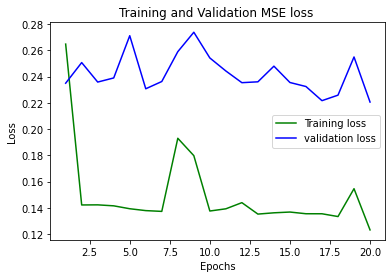

3 neurons 0.3 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 89s 109ms/step - loss: 0.9907 - val_loss: 0.9132
Epoch 2/20
753/753 [==============================] - 79s 105ms/step - loss: 0.8396 - val_loss: 0.9744
Epoch 3/20
753/753 [==============================] - 88s 117ms/step - loss: 0.7921 - val_loss: 0.9384
Epoch 4/20
753/753 [==============================] - 90s 119ms/step - loss: 0.7909 - val_loss: 0.9693
Epoch 5/20
753/753 [==============================] - 88s 117ms/step - loss: 0.7836 - val_loss: 0.9713
Epoch 6/20
753/753 [==============================] - 83s 110ms/step - loss: 0.7757 - val_loss: 1.0152
Epoch 7/20
753/753 [==============================] - 83s 110ms/step - loss: 0.7694 - val_loss: 0.9910
Epoch 8/20
753/753 [==============================] - 83s 111ms/step - loss: 0.7697 - val_loss: 1.0289
Epoch 9/20
753/753 [==============================] - 81s 108ms/step - loss: 0.7733 - val_loss: 1.0256
Epoch 10/20
753/753 [============

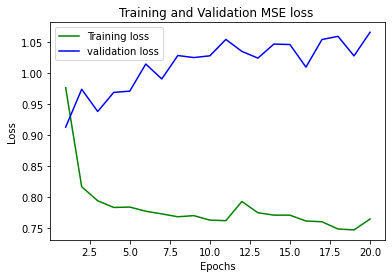

3 neurons 0.4 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 90s 110ms/step - loss: 0.9758 - val_loss: 0.9300
Epoch 2/20
753/753 [==============================] - 89s 119ms/step - loss: 0.9130 - val_loss: 0.9043
Epoch 3/20
753/753 [==============================] - 88s 117ms/step - loss: 0.8916 - val_loss: 0.9044
Epoch 4/20
753/753 [==============================] - 87s 115ms/step - loss: 0.8972 - val_loss: 0.9062
Epoch 5/20
753/753 [==============================] - 81s 108ms/step - loss: 0.8930 - val_loss: 0.9032
Epoch 6/20
753/753 [==============================] - 81s 108ms/step - loss: 0.9305 - val_loss: 0.9628
Epoch 7/20
753/753 [==============================] - 82s 109ms/step - loss: 0.9507 - val_loss: 0.9600
Epoch 8/20
753/753 [==============================] - 79s 105ms/step - loss: 0.9546 - val_loss: 0.9592
Epoch 9/20
753/753 [==============================] - 77s 102ms/step - loss: 0.9566 - val_loss: 0.9595
Epoch 10/20
753/753 [============

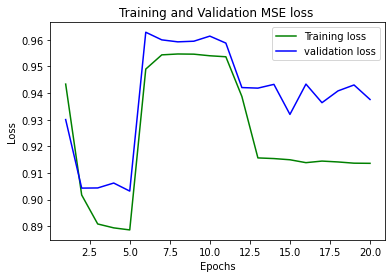

3 neurons 0.5 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 85s 103ms/step - loss: 0.3707 - val_loss: 0.3248
Epoch 2/20
753/753 [==============================] - 77s 103ms/step - loss: 0.2037 - val_loss: 0.3045
Epoch 3/20
753/753 [==============================] - 78s 103ms/step - loss: 0.2026 - val_loss: 0.3015
Epoch 4/20
753/753 [==============================] - 77s 102ms/step - loss: 0.1972 - val_loss: 0.3053
Epoch 5/20
753/753 [==============================] - 76s 101ms/step - loss: 0.1978 - val_loss: 0.2961
Epoch 6/20
753/753 [==============================] - 76s 101ms/step - loss: 0.1919 - val_loss: 0.3206
Epoch 7/20
753/753 [==============================] - 75s 100ms/step - loss: 0.2033 - val_loss: 0.3017
Epoch 8/20
753/753 [==============================] - 75s 100ms/step - loss: 0.1956 - val_loss: 0.3104
Epoch 9/20
753/753 [==============================] - 76s 101ms/step - loss: 0.1964 - val_loss: 0.3360
Epoch 10/20
753/753 [============

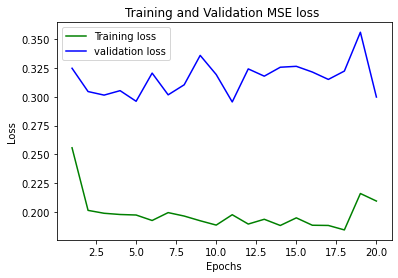

6 neurons 0.2 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 88s 107ms/step - loss: 0.2942 - val_loss: 0.3112
Epoch 2/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1352 - val_loss: 0.3006
Epoch 3/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1340 - val_loss: 0.2748
Epoch 4/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1235 - val_loss: 0.2478
Epoch 5/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1183 - val_loss: 0.2271
Epoch 6/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1177 - val_loss: 0.2184
Epoch 7/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1054 - val_loss: 0.1971
Epoch 8/20
753/753 [==============================] - 80s 107ms/step - loss: 0.0926 - val_loss: 0.1959
Epoch 9/20
753/753 [==============================] - 80s 107ms/step - loss: 0.0936 - val_loss: 0.1918
Epoch 10/20
753/753 [============

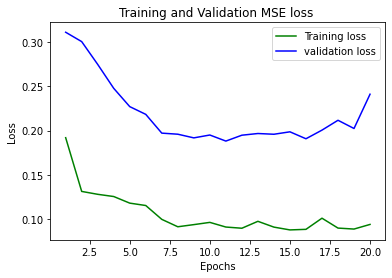

6 neurons 0.3 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 89s 109ms/step - loss: 0.3725 - val_loss: 0.2386
Epoch 2/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1032 - val_loss: 0.2123
Epoch 3/20
753/753 [==============================] - 81s 108ms/step - loss: 0.0962 - val_loss: 0.2040
Epoch 4/20
753/753 [==============================] - 81s 108ms/step - loss: 0.0960 - val_loss: 0.2301
Epoch 5/20
753/753 [==============================] - 81s 107ms/step - loss: 0.0958 - val_loss: 0.2934
Epoch 6/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1097 - val_loss: 0.2014
Epoch 7/20
753/753 [==============================] - 82s 108ms/step - loss: 0.0942 - val_loss: 0.2015
Epoch 8/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0949 - val_loss: 0.2077
Epoch 9/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0992 - val_loss: 0.2173
Epoch 10/20
753/753 [============

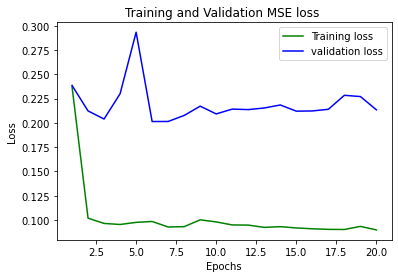

6 neurons 0.4 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 88s 107ms/step - loss: 0.4569 - val_loss: 0.3557
Epoch 2/20
753/753 [==============================] - 80s 107ms/step - loss: 0.2596 - val_loss: 0.2450
Epoch 3/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1487 - val_loss: 0.2347
Epoch 4/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1250 - val_loss: 0.2305
Epoch 5/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1182 - val_loss: 0.2460
Epoch 6/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1147 - val_loss: 0.2336
Epoch 7/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1069 - val_loss: 0.2252
Epoch 8/20
753/753 [==============================] - 80s 106ms/step - loss: 0.1060 - val_loss: 0.2263
Epoch 9/20
753/753 [==============================] - 80s 106ms/step - loss: 0.1036 - val_loss: 0.2173
Epoch 10/20
753/753 [============

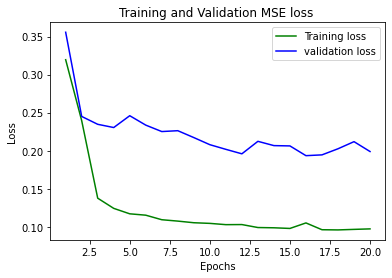

6 neurons 0.5 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 88s 108ms/step - loss: 0.4028 - val_loss: 0.3522
Epoch 2/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1483 - val_loss: 0.3272
Epoch 3/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1446 - val_loss: 0.3080
Epoch 4/20
753/753 [==============================] - 80s 106ms/step - loss: 0.1432 - val_loss: 0.3150
Epoch 5/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1406 - val_loss: 0.3078
Epoch 6/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1307 - val_loss: 0.3147
Epoch 7/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1170 - val_loss: 0.3030
Epoch 8/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1092 - val_loss: 0.2848
Epoch 9/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1119 - val_loss: 0.2776
Epoch 10/20
753/753 [============

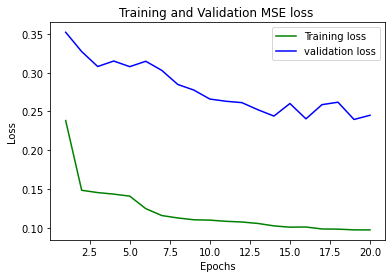

8 neurons 0.2 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 89s 109ms/step - loss: 0.2967 - val_loss: 0.2161
Epoch 2/20
753/753 [==============================] - 82s 108ms/step - loss: 0.1045 - val_loss: 0.2113
Epoch 3/20
753/753 [==============================] - 81s 108ms/step - loss: 0.0976 - val_loss: 0.2005
Epoch 4/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1000 - val_loss: 0.1936
Epoch 5/20
753/753 [==============================] - 81s 108ms/step - loss: 0.0973 - val_loss: 0.1895
Epoch 6/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0968 - val_loss: 0.1861
Epoch 7/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0909 - val_loss: 0.1886
Epoch 8/20
753/753 [==============================] - 81s 108ms/step - loss: 0.0973 - val_loss: 0.2035
Epoch 9/20
753/753 [==============================] - 81s 108ms/step - loss: 0.0956 - val_loss: 0.1944
Epoch 10/20
753/753 [============

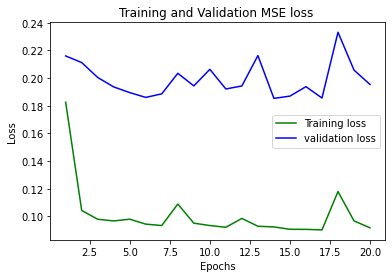

8 neurons 0.3 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 90s 109ms/step - loss: 0.2860 - val_loss: 0.2907
Epoch 2/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1140 - val_loss: 0.2271
Epoch 3/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1014 - val_loss: 0.2230
Epoch 4/20
753/753 [==============================] - 83s 110ms/step - loss: 0.1003 - val_loss: 0.2185
Epoch 5/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0924 - val_loss: 0.2324
Epoch 6/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0924 - val_loss: 0.2240
Epoch 7/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0898 - val_loss: 0.2218
Epoch 8/20
753/753 [==============================] - 82s 108ms/step - loss: 0.0891 - val_loss: 0.2381
Epoch 9/20
753/753 [==============================] - 81s 108ms/step - loss: 0.0870 - val_loss: 0.2215
Epoch 10/20
753/753 [============

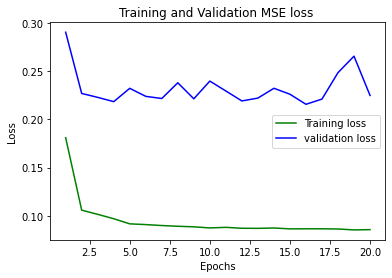

8 neurons 0.4 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 90s 109ms/step - loss: 0.3349 - val_loss: 0.2524
Epoch 2/20
753/753 [==============================] - 82s 108ms/step - loss: 0.1369 - val_loss: 0.2368
Epoch 3/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1033 - val_loss: 0.2951
Epoch 4/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1024 - val_loss: 0.2392
Epoch 5/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0971 - val_loss: 0.2404
Epoch 6/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0954 - val_loss: 0.2401
Epoch 7/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0975 - val_loss: 0.2454
Epoch 8/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0936 - val_loss: 0.2436
Epoch 9/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0960 - val_loss: 0.2500
Epoch 10/20
753/753 [============

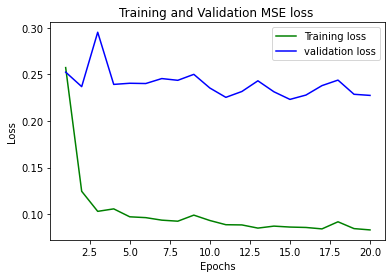

8 neurons 0.5 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 90s 110ms/step - loss: 0.3105 - val_loss: 0.2535
Epoch 2/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1097 - val_loss: 0.2298
Epoch 3/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1070 - val_loss: 0.2205
Epoch 4/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1025 - val_loss: 0.2228
Epoch 5/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1018 - val_loss: 0.2105
Epoch 6/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0983 - val_loss: 0.2137
Epoch 7/20
753/753 [==============================] - 82s 108ms/step - loss: 0.1000 - val_loss: 0.2021
Epoch 8/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0954 - val_loss: 0.2066
Epoch 9/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0924 - val_loss: 0.2208
Epoch 10/20
753/753 [============

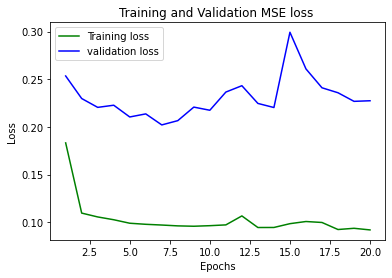

10 neurons 0.2 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 92s 111ms/step - loss: 0.2809 - val_loss: 0.1988
Epoch 2/20
753/753 [==============================] - 83s 111ms/step - loss: 0.0986 - val_loss: 0.2030
Epoch 3/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0931 - val_loss: 0.2047
Epoch 4/20
753/753 [==============================] - 83s 111ms/step - loss: 0.0907 - val_loss: 0.1968
Epoch 5/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0883 - val_loss: 0.2024
Epoch 6/20
753/753 [==============================] - 84s 111ms/step - loss: 0.0878 - val_loss: 0.1910
Epoch 7/20
753/753 [==============================] - 83s 111ms/step - loss: 0.0893 - val_loss: 0.2024
Epoch 8/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0848 - val_loss: 0.1983
Epoch 9/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0817 - val_loss: 0.1974
Epoch 10/20
753/753 [===========

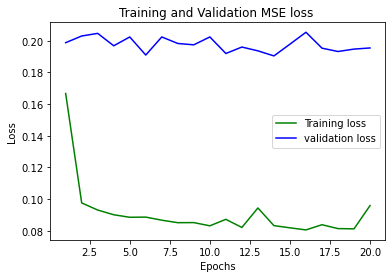

10 neurons 0.3 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 91s 110ms/step - loss: 0.2872 - val_loss: 0.2241
Epoch 2/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0970 - val_loss: 0.2115
Epoch 3/20
753/753 [==============================] - 84s 111ms/step - loss: 0.0893 - val_loss: 0.2132
Epoch 4/20
753/753 [==============================] - 84s 111ms/step - loss: 0.0849 - val_loss: 0.2331
Epoch 5/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0849 - val_loss: 0.2217
Epoch 6/20
753/753 [==============================] - 83s 111ms/step - loss: 0.0830 - val_loss: 0.2159
Epoch 7/20
753/753 [==============================] - 84s 112ms/step - loss: 0.0837 - val_loss: 0.2355
Epoch 8/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0846 - val_loss: 0.2131
Epoch 9/20
753/753 [==============================] - 84s 111ms/step - loss: 0.0842 - val_loss: 0.2048
Epoch 10/20
753/753 [===========

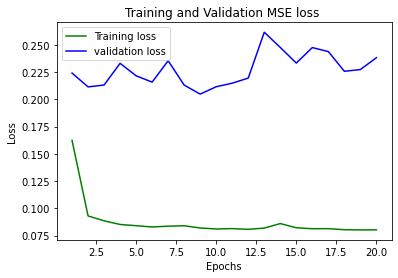

10 neurons 0.4 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 91s 111ms/step - loss: 0.4212 - val_loss: 0.3572
Epoch 2/20
753/753 [==============================] - 83s 110ms/step - loss: 0.2600 - val_loss: 0.3316
Epoch 3/20
753/753 [==============================] - 83s 110ms/step - loss: 0.2490 - val_loss: 0.3387
Epoch 4/20
753/753 [==============================] - 83s 111ms/step - loss: 0.2548 - val_loss: 0.3340
Epoch 5/20
753/753 [==============================] - 83s 110ms/step - loss: 0.2365 - val_loss: 0.3366
Epoch 6/20
753/753 [==============================] - 83s 110ms/step - loss: 0.2384 - val_loss: 0.3394
Epoch 7/20
753/753 [==============================] - 83s 110ms/step - loss: 0.2391 - val_loss: 0.3423
Epoch 8/20
753/753 [==============================] - 84s 111ms/step - loss: 0.2370 - val_loss: 0.3616
Epoch 9/20
753/753 [==============================] - 83s 111ms/step - loss: 0.2354 - val_loss: 0.3477
Epoch 10/20
753/753 [===========

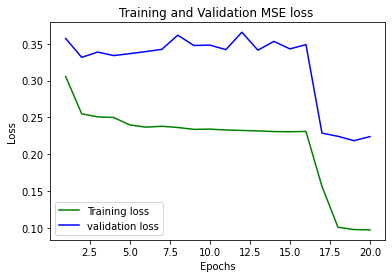

10 neurons 0.5 sparsity 1113 random seed
Epoch 1/20
753/753 [==============================] - 92s 112ms/step - loss: 0.3511 - val_loss: 0.2294
Epoch 2/20
753/753 [==============================] - 84s 111ms/step - loss: 0.1091 - val_loss: 0.2201
Epoch 3/20
753/753 [==============================] - 84s 112ms/step - loss: 0.0965 - val_loss: 0.2179
Epoch 4/20
753/753 [==============================] - 84s 112ms/step - loss: 0.0969 - val_loss: 0.2154
Epoch 5/20
753/753 [==============================] - 85s 112ms/step - loss: 0.0926 - val_loss: 0.2195
Epoch 6/20
753/753 [==============================] - 84s 112ms/step - loss: 0.0896 - val_loss: 0.2182
Epoch 7/20
753/753 [==============================] - 84s 112ms/step - loss: 0.0875 - val_loss: 0.2130
Epoch 8/20
753/753 [==============================] - 85s 112ms/step - loss: 0.0940 - val_loss: 0.2178
Epoch 9/20
753/753 [==============================] - 84s 112ms/step - loss: 0.0855 - val_loss: 0.2198
Epoch 10/20
753/753 [===========

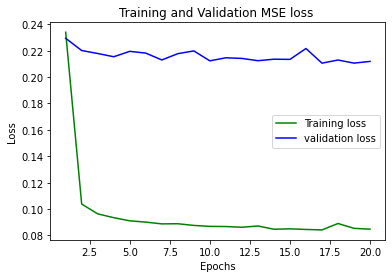

3 neurons 0.2 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 90s 109ms/step - loss: 0.4360 - val_loss: 0.3818
Epoch 2/20
753/753 [==============================] - 79s 105ms/step - loss: 0.2698 - val_loss: 0.3572
Epoch 3/20
753/753 [==============================] - 79s 105ms/step - loss: 0.2116 - val_loss: 0.2745
Epoch 4/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1973 - val_loss: 0.2740
Epoch 5/20
753/753 [==============================] - 79s 105ms/step - loss: 0.1969 - val_loss: 0.2812
Epoch 6/20
753/753 [==============================] - 78s 104ms/step - loss: 0.1912 - val_loss: 0.2750
Epoch 7/20
753/753 [==============================] - 77s 102ms/step - loss: 0.1757 - val_loss: 0.3224
Epoch 8/20
753/753 [==============================] - 77s 102ms/step - loss: 0.3676 - val_loss: 0.9504
Epoch 9/20
753/753 [==============================] - 77s 103ms/step - loss: 0.9220 - val_loss: 0.9449
Epoch 10/20
753/753 [============

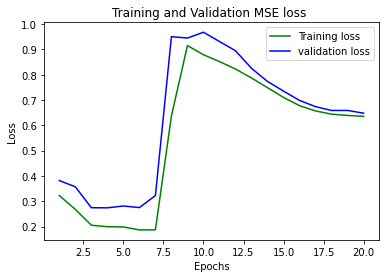

3 neurons 0.3 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 85s 104ms/step - loss: 0.4600 - val_loss: 0.2449
Epoch 2/20
753/753 [==============================] - 76s 101ms/step - loss: 0.1544 - val_loss: 0.2383
Epoch 3/20
753/753 [==============================] - 76s 102ms/step - loss: 0.1435 - val_loss: 0.2349
Epoch 4/20
753/753 [==============================] - 77s 102ms/step - loss: 0.1409 - val_loss: 0.2519
Epoch 5/20
753/753 [==============================] - 77s 102ms/step - loss: 0.1227 - val_loss: 0.2498
Epoch 6/20
753/753 [==============================] - 77s 102ms/step - loss: 0.1213 - val_loss: 0.2612
Epoch 7/20
753/753 [==============================] - 76s 101ms/step - loss: 0.1280 - val_loss: 0.2780
Epoch 8/20
753/753 [==============================] - 77s 102ms/step - loss: 0.1234 - val_loss: 0.2783
Epoch 9/20
753/753 [==============================] - 76s 101ms/step - loss: 0.1274 - val_loss: 0.2646
Epoch 10/20
753/753 [============

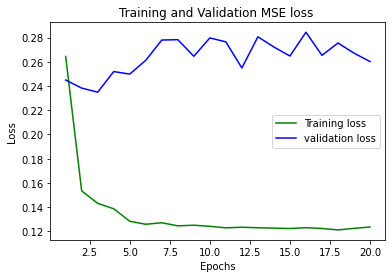

3 neurons 0.4 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 86s 103ms/step - loss: 0.4203 - val_loss: 0.2746
Epoch 2/20
753/753 [==============================] - 79s 105ms/step - loss: 0.1719 - val_loss: 0.2543
Epoch 3/20
753/753 [==============================] - 78s 104ms/step - loss: 0.1679 - val_loss: 0.2389
Epoch 4/20
753/753 [==============================] - 78s 103ms/step - loss: 0.1691 - val_loss: 0.2470
Epoch 5/20
753/753 [==============================] - 78s 104ms/step - loss: 0.1637 - val_loss: 0.2408
Epoch 6/20
753/753 [==============================] - 78s 104ms/step - loss: 0.1653 - val_loss: 0.2378
Epoch 7/20
753/753 [==============================] - 77s 103ms/step - loss: 0.1636 - val_loss: 0.2357
Epoch 8/20
753/753 [==============================] - 78s 103ms/step - loss: 0.1638 - val_loss: 0.2343
Epoch 9/20
753/753 [==============================] - 78s 103ms/step - loss: 0.1640 - val_loss: 0.2350
Epoch 10/20
753/753 [============

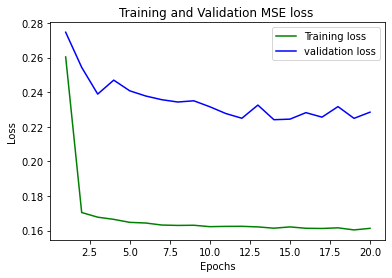

3 neurons 0.5 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 86s 104ms/step - loss: 0.9828 - val_loss: 0.9845
Epoch 2/20
753/753 [==============================] - 78s 104ms/step - loss: 0.9690 - val_loss: 0.9892
Epoch 3/20
753/753 [==============================] - 79s 105ms/step - loss: 0.9672 - val_loss: 0.9833
Epoch 4/20
753/753 [==============================] - 77s 102ms/step - loss: 0.9712 - val_loss: 0.9838
Epoch 5/20
753/753 [==============================] - 77s 102ms/step - loss: 0.9707 - val_loss: 0.9840
Epoch 6/20
753/753 [==============================] - 77s 102ms/step - loss: 0.9723 - val_loss: 0.9833
Epoch 7/20
753/753 [==============================] - 78s 104ms/step - loss: 0.9673 - val_loss: 0.9848
Epoch 8/20
753/753 [==============================] - 77s 102ms/step - loss: 0.9622 - val_loss: 0.9851
Epoch 9/20
753/753 [==============================] - 77s 102ms/step - loss: 0.9634 - val_loss: 0.9834
Epoch 10/20
753/753 [============

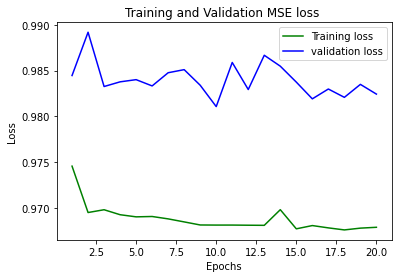

6 neurons 0.2 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 90s 109ms/step - loss: 0.3432 - val_loss: 0.2198
Epoch 2/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1318 - val_loss: 0.1908
Epoch 3/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1084 - val_loss: 0.1827
Epoch 4/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1029 - val_loss: 0.1850
Epoch 5/20
753/753 [==============================] - 83s 110ms/step - loss: 0.1002 - val_loss: 0.1790
Epoch 6/20
753/753 [==============================] - 83s 111ms/step - loss: 0.0979 - val_loss: 0.1747
Epoch 7/20
753/753 [==============================] - 85s 113ms/step - loss: 0.0976 - val_loss: 0.1723
Epoch 8/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0979 - val_loss: 0.1789
Epoch 9/20
753/753 [==============================] - 83s 110ms/step - loss: 0.0914 - val_loss: 0.1770
Epoch 10/20
753/753 [============

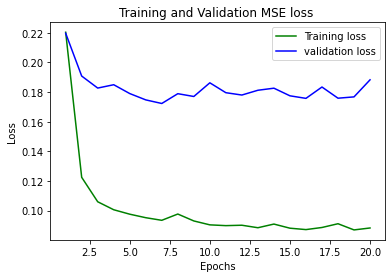

6 neurons 0.3 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 89s 108ms/step - loss: 0.3656 - val_loss: 0.2921
Epoch 2/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1541 - val_loss: 0.2493
Epoch 3/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1347 - val_loss: 0.2375
Epoch 4/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1307 - val_loss: 0.2395
Epoch 5/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1314 - val_loss: 0.2360
Epoch 6/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1276 - val_loss: 0.2367
Epoch 7/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1294 - val_loss: 0.2392
Epoch 8/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1280 - val_loss: 0.2366
Epoch 9/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1222 - val_loss: 0.2511
Epoch 10/20
753/753 [============

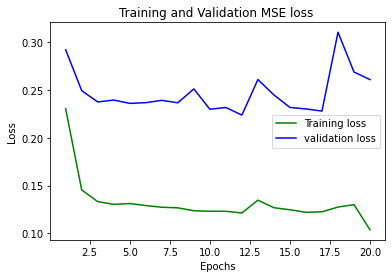

6 neurons 0.4 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 89s 107ms/step - loss: 0.3498 - val_loss: 0.3008
Epoch 2/20
753/753 [==============================] - 82s 108ms/step - loss: 0.1646 - val_loss: 0.2482
Epoch 3/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1247 - val_loss: 0.2321
Epoch 4/20
753/753 [==============================] - 81s 108ms/step - loss: 0.1076 - val_loss: 0.2538
Epoch 5/20
753/753 [==============================] - 82s 109ms/step - loss: 0.2525 - val_loss: 0.3424
Epoch 6/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1651 - val_loss: 0.2328
Epoch 7/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1079 - val_loss: 0.2208
Epoch 8/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1059 - val_loss: 0.2200
Epoch 9/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1019 - val_loss: 0.2225
Epoch 10/20
753/753 [============

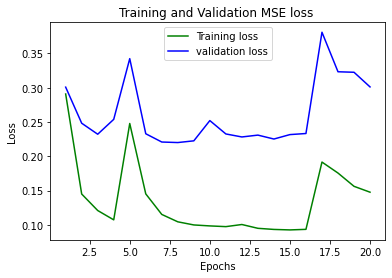

6 neurons 0.5 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 88s 107ms/step - loss: 0.3996 - val_loss: 0.3803
Epoch 2/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1617 - val_loss: 0.3560
Epoch 3/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1634 - val_loss: 0.4410
Epoch 4/20
753/753 [==============================] - 80s 107ms/step - loss: 0.2143 - val_loss: 0.3182
Epoch 5/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1435 - val_loss: 0.3417
Epoch 6/20
753/753 [==============================] - 80s 106ms/step - loss: 0.1342 - val_loss: 0.2874
Epoch 7/20
753/753 [==============================] - 81s 107ms/step - loss: 0.1215 - val_loss: 0.2589
Epoch 8/20
753/753 [==============================] - 80s 106ms/step - loss: 0.1164 - val_loss: 0.2837
Epoch 9/20
753/753 [==============================] - 80s 107ms/step - loss: 0.1166 - val_loss: 0.2786
Epoch 10/20
753/753 [============

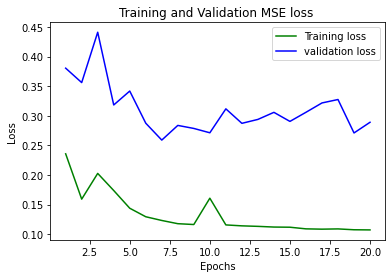

8 neurons 0.2 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 91s 110ms/step - loss: 0.3256 - val_loss: 0.2047
Epoch 2/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1158 - val_loss: 0.2293
Epoch 3/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0938 - val_loss: 0.2181
Epoch 4/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0880 - val_loss: 0.2216
Epoch 5/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0840 - val_loss: 0.2319
Epoch 6/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0891 - val_loss: 0.2274
Epoch 7/20
753/753 [==============================] - 82s 108ms/step - loss: 0.0868 - val_loss: 0.2212
Epoch 8/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0819 - val_loss: 0.2223
Epoch 9/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0829 - val_loss: 0.2410
Epoch 10/20
753/753 [============

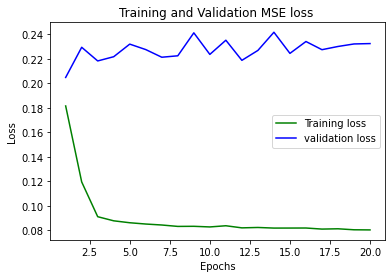

8 neurons 0.3 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 91s 110ms/step - loss: 0.4923 - val_loss: 0.2399
Epoch 2/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1105 - val_loss: 0.2425
Epoch 3/20
753/753 [==============================] - 83s 110ms/step - loss: 0.1013 - val_loss: 0.2234
Epoch 4/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0977 - val_loss: 0.2396
Epoch 5/20
753/753 [==============================] - 85s 113ms/step - loss: 0.1003 - val_loss: 0.2255
Epoch 6/20
753/753 [==============================] - 87s 115ms/step - loss: 0.0942 - val_loss: 0.2211
Epoch 7/20
753/753 [==============================] - 82s 109ms/step - loss: 0.1002 - val_loss: 0.2175
Epoch 8/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0933 - val_loss: 0.2136
Epoch 9/20
753/753 [==============================] - 82s 109ms/step - loss: 0.0997 - val_loss: 0.2148
Epoch 10/20
753/753 [============

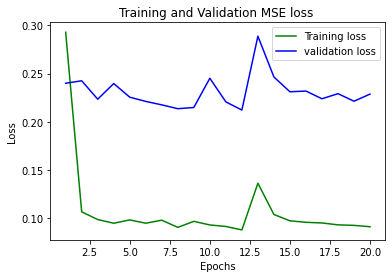

8 neurons 0.4 sparsity 1114 random seed
Epoch 1/20
753/753 [==============================] - 90s 110ms/step - loss: 0.4186 - val_loss: 0.2533
Epoch 2/20
753/753 [==============================] - 83s 111ms/step - loss: 0.1272 - val_loss: 0.2329
Epoch 3/20
753/753 [==============================] - 86s 114ms/step - loss: 0.1215 - val_loss: 0.2299
Epoch 4/20
753/753 [==============================] - 86s 115ms/step - loss: 0.1281 - val_loss: 0.2306
Epoch 5/20
753/753 [==============================] - 87s 115ms/step - loss: 0.1216 - val_loss: 0.2315
Epoch 6/20
753/753 [==============================] - 87s 116ms/step - loss: 0.1202 - val_loss: 0.2229
Epoch 7/20
102/753 [===>..........................] - ETA: 1:12 - loss: 0.1153

In [ ]:
# Experiment with hyparameters - number of neurons, sparsity
for r in random_seeds:
    all_test_loss[r] = []
    for i in neurons:
        for j in sparsity: 
            print(i,'neurons',j,'sparsity',r,'random seed')
            arch = kerasncp.wirings.Random(i, 1, sparsity_level=j, random_seed = r)
            rnn_cell = LTCCell(arch)
            model = tf.keras.models.Sequential(
                [
                    tf.keras.Input((None, 7)),
                    tf.keras.layers.RNN(rnn_cell, return_sequences=True),
                ]
            )
            model.compile(
                optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
            )

            traffic_ncp_history = model.fit(x=train_x, y=train_y, batch_size=batch_size_n, epochs=epochs_n, validation_data=(valid_x,valid_y))
            test_loss = round(model.evaluate(test_x,test_y, batch_size_n),4)
            all_test_loss[r].append(test_loss)
            loss_train = traffic_ncp_history.history['loss']
            loss_val = traffic_ncp_history.history['val_loss']
            epochs = range(1,epochs_n+1)
            plt.plot(epochs, loss_train, 'g', label='Training loss')
            plt.plot(epochs, loss_val, 'b', label='validation loss')
            plt.title('Training and Validation MSE loss ')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()